In [1]:
import numpy as np
import pandas as pd
from keras import models, layers

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import json
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
df = pd.read_csv('../data/datasets/training_data_small_track_symetric.csv')
print(f'{df.shape=}')
df.sample(5)

df.shape=(5940, 19)


,steering_angle,waypoint1_lat,waypoint1_lon,waypoint2_lat,waypoint2_lon,waypoint3_lat,waypoint3_lon,waypoint4_lat,waypoint4_lon,waypoint5_lat,waypoint5_lon,waypoint6_lat,waypoint6_lon,waypoint7_lat,waypoint7_lon,waypoint8_lat,waypoint8_lon,waypoint9_lat,waypoint9_lon
4832,-0.0,0.479822,-0.900104,1.932479,-3.967908,1.899323,-7.304892,-0.128438,-9.981675,-3.130971,-11.529131,-6.437959,-12.300511,-9.776048,-12.945478,-13.168360,-13.136023,-16.566117,-13.250794
4131,0.2,0.569471,-0.371157,2.976439,-2.759880,4.936002,-5.536966,6.827206,-8.360388,8.415203,-11.366480,10.014551,-14.366765,11.613883,-17.367025,13.213259,-20.367321,14.716041,-23.413548
5787,0.3,-1.701422,2.080488,-1.957158,5.495113,-1.957159,8.895078,-2.351914,12.263848,-3.042553,15.592782,-3.723504,18.923860,-4.404469,22.254961,-5.085410,25.586044,-5.197856,28.955523
4197,0.1,1.791738,-2.042395,3.724157,-4.839438,5.545969,-7.705144,7.135092,-10.710675,8.734420,-13.710939,10.333772,-16.711219,11.933128,-19.711495,13.314663,-22.807440,13.067019,-26.132056
5233,0.2,-1.283152,-0.450034,-4.600623,-1.181113,-7.942271,-1.804189,-11.337104,-1.964023,-14.734930,-2.054971,-17.997189,-1.266430,-20.109754,1.316803,-20.237663,4.756473,-20.237664,8.156438


In [3]:
X = df.drop(columns=['steering_angle'])
y = df['steering_angle']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4752, 18), (1188, 18), (4752,), (1188,))

In [4]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from datetime import datetime
from keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, Flatten
from keras.models import Model

# Define input shape
input_shape = (X_train.shape[1],)
inputs = Input(shape=input_shape)

# Expand dims to add sequence dimension (required for transformer)
x = inputs[:, None, :]  # shape: (batch, 1, features)

# Transformer block
attn_output = MultiHeadAttention(num_heads=2, key_dim=32)(x, x)
x = LayerNormalization(epsilon=1e-6)(attn_output + x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.1)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs)


timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
checkpoint = ModelCheckpoint(f'../weights/best_NN_{timestamp}.h5', monitor='val_loss', save_best_only=True, mode='min')

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 18)]         0           []                               
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 1, 18)       0           ['input_1[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 multi_head_attention (MultiHea  (None, 1, 18)       4818        ['tf.__operators__.getitem[0][0]'
 dAttention)                                                     , 'tf.__operators__.getitem[0][0]
                                                                 ']                           

In [5]:
EPOCHS = 10
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=32,
    callbacks=[checkpoint],
    verbose=1
)

Epoch 1/10
149/149 [==============================] - 6s 17ms/step - loss: 0.0137 - mae: 0.0876 - val_loss: 0.0052 - val_mae: 0.0520
Epoch 2/10
149/149 [==============================] - 2s 12ms/step - loss: 0.0064 - mae: 0.0617 - val_loss: 0.0033 - val_mae: 0.0425
Epoch 3/10
149/149 [==============================] - 2s 13ms/step - loss: 0.0049 - mae: 0.0545 - val_loss: 0.0035 - val_mae: 0.0451
Epoch 4/10
149/149 [==============================] - 1s 10ms/step - loss: 0.0041 - mae: 0.0499 - val_loss: 0.0030 - val_mae: 0.0417
Epoch 5/10
149/149 [==============================] - 2s 12ms/step - loss: 0.0039 - mae: 0.0488 - val_loss: 0.0028 - val_mae: 0.0418
Epoch 6/10
149/149 [==============================] - 2s 10ms/step - loss: 0.0035 - mae: 0.0455 - val_loss: 0.0026 - val_mae: 0.0386
Epoch 7/10
149/149 [==============================] - 2s 13ms/step - loss: 0.0030 - mae: 0.0424 - val_loss: 0.0024 - val_mae: 0.0376
Epoch 8/10
149/149 [==============================] - 2s 10ms/step - 

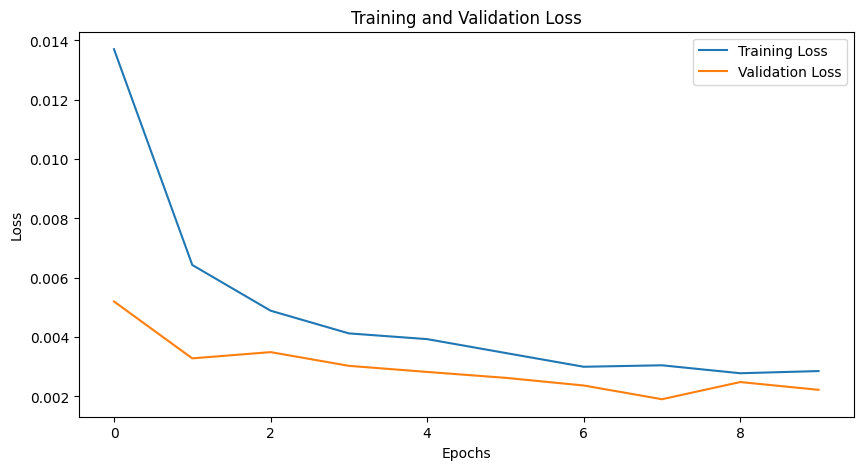

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

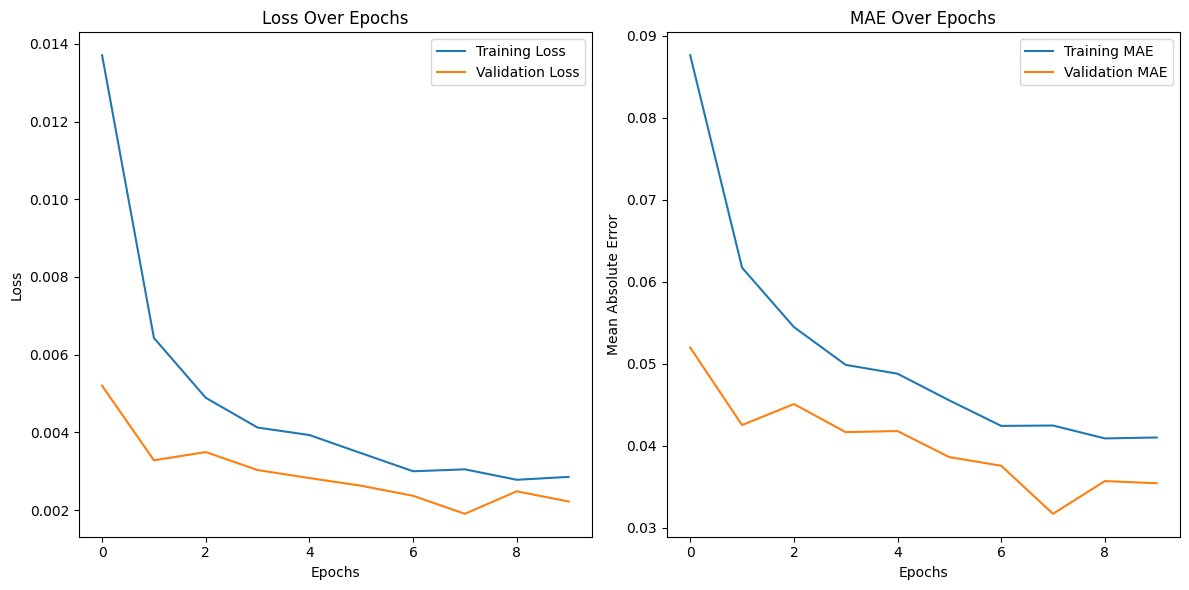

In [7]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('MAE Over Epochs')

plt.tight_layout()
plt.show()

In [8]:
model.load_weights(checkpoint.filepath)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

metrics_df = pd.DataFrame({
    "Metric": ["Mean Squared Error (MSE)", "Mean Absolute Error (MAE)", "R-squared (R2)"],
    "Value": [mse, mae, r2]
})

metrics_df

38/38 [==============================] - 1s 7ms/step


,Metric,Value
0,Mean Squared Error (MSE),0.001906
1,Mean Absolute Error (MAE),0.031704
2,R-squared (R2),0.918222


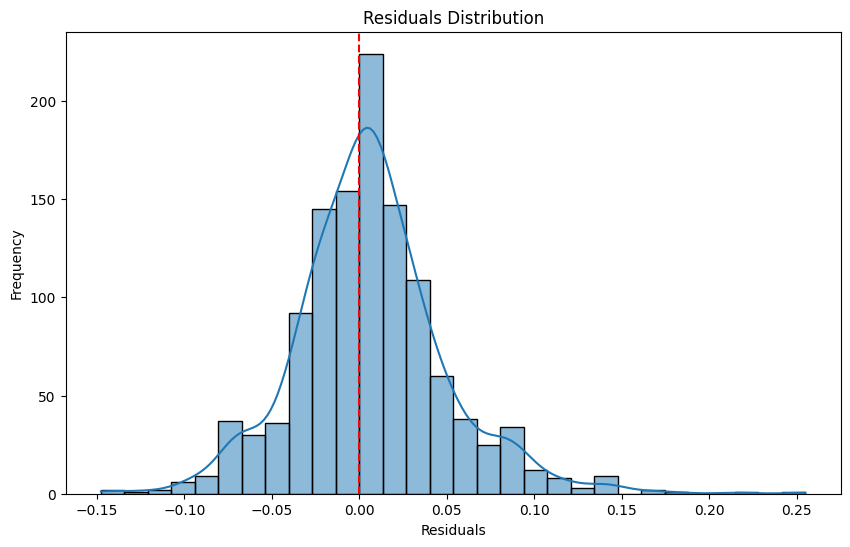

In [9]:
residuals = y_test - y_pred.flatten()
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()

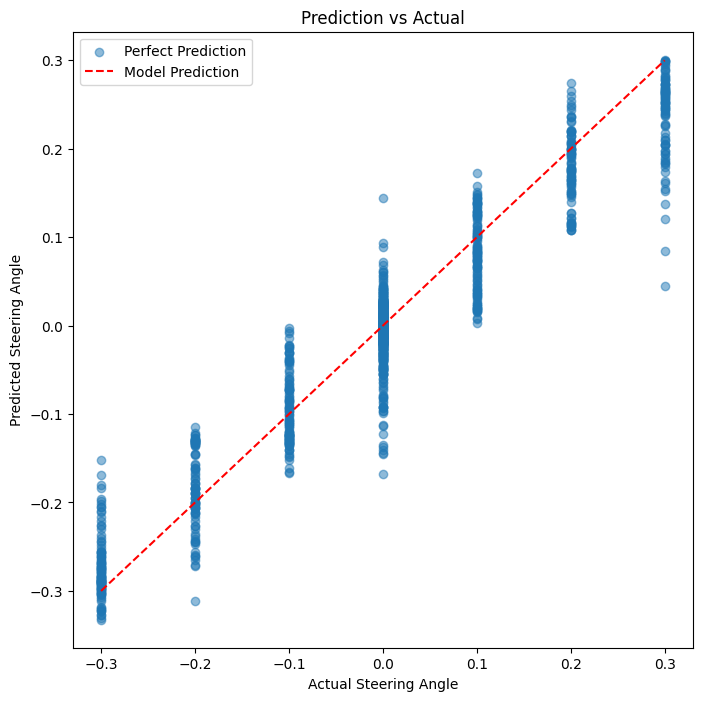

In [10]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Steering Angle')
plt.ylabel('Predicted Steering Angle')
plt.title('Prediction vs Actual')
plt.legend(['Perfect Prediction', 'Model Prediction'])
plt.show()

In [11]:
name = 'transformer_2_32_128_64'
model_json = model.to_json()
with open(f'../models/{name}.json', 'w') as json_file:
    json.dump(json.loads(model_json), json_file, indent=4)

In [12]:
metadata = {
    "model_name": name,
    "model_path": f"../models/{name}.json",
    "timestamp": timestamp,
    "input_shape": list(X_train.shape[1:]),
    "output_shape": [1],
    "optimizer": {
        "type": "Adam",
        "learning_rate": 0.001
    },
    "loss_function": "mse",
    "metrics": ["mae"],
    "training": {
        "epochs": len(history.history['loss']),
        "batch_size": 32,
        "best_model_path": checkpoint.filepath,
        "final_training_loss": history.history['loss'][-1],
        "final_validation_loss": history.history['val_loss'][-1]
    },
    "evaluation": {
        "mse": mse,
        "mae": mae,
        "r2": r2
    }
}

try:
    with open("metadata.jsonl", "r+") as f:
        lines = f.readlines()
        entry = json.dumps(metadata) + "\n"
        if entry not in lines:
            f.write(entry)
except FileNotFoundError:
    with open("metadata.jsonl", "w") as f:
        f.write(json.dumps(metadata) + "\n")

In [13]:
with open("metadata.jsonl", "r") as f:
    lines = f.readlines()

print(json.dumps(json.loads(lines[-1]), indent=4))

{
    "model_name": "transformer_2_32_128_64",
    "model_path": "../models/transformer_2_32_128_64.json",
    "timestamp": "20250601_133331",
    "input_shape": [
        18
    ],
    "output_shape": [
        1
    ],
    "optimizer": {
        "type": "Adam",
        "learning_rate": 0.001
    },
    "loss_function": "mse",
    "metrics": [
        "mae"
    ],
    "training": {
        "epochs": 10,
        "batch_size": 32,
        "best_model_path": "../weights/best_NN_20250601_133331.h5",
        "final_training_loss": 0.002855429658666253,
        "final_validation_loss": 0.0022232297342270613
    },
    "evaluation": {
        "mse": 0.0019060929877004237,
        "mae": 0.03170400429810014,
        "r2": 0.9182215773232487
    }
}
